In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import seaborn as sns
import ratmetab
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if os.getlogin() == 'jonesa7':
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
    datapath = {
        'blood new': 'blood_27_Oct_2022',
        'brain new': 'brain_27_Oct_2022',
        'blood old': 'old_blood_17_Nov_2022',
        'brain old': 'old_brain_17_Nov_2022',
               }
    data = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True) for k, v in datapath.items()}
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'

data.update({tissue: pd.concat([data[tissue + ' new'], data[tissue + ' old']], axis=0, join='outer') for tissue in ['blood', 'brain']})
data['brain']

,LIscore,Group,Cholic acid,Taurocholic acid,Taurochenodeoxycholic acid,Tauromuricholic acid (alpha + beta),Carnitine,Acetylcarnitine,Propionylcarnitine,Malonylcarnitine (Hydroxybutyrylcarnitine),...,Dihydroceramide C10:1,Ceramide C14:0,Ceramide C15:1,2-Hydroxyacylceramide C20:0,2-Hydroxyacyldihydroceramide C28:0,Phosphatidylethanolamine aa 20:0,Phosphatidylethanolamine aa 22:2,Phosphatidylethanolamine ae 38:2,Phosphatidylethanolamine ae 42:1,Phosphatidylserine aa 40:5
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,NaN,NaN,NaN,NaN,11.034,1.521,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1158,201,AU,NaN,0.32700,0.03300,0.27960,10.904,4.107,0.142000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1172,155,AU,NaN,0.37800,0.01784,0.21040,10.132,4.187,0.072465,0.060798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,NaN,0.14600,NaN,0.06520,10.024,4.249,0.146000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,291,AI,NaN,NaN,NaN,NaN,11.611,3.001,NaN,0.077633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,200,Y,NaN,0.05720,0.01228,0.08160,41.726,10.425,NaN,0.296000,...,NaN,0.01079,NaN,0.11100,0.0084,0.108,0.199,0.476,0.562,39.963
298,212,Y,0.0544,0.02564,0.01232,0.02828,40.899,10.093,NaN,0.258000,...,NaN,0.00782,NaN,0.07611,NaN,0.100,0.175,0.364,0.390,NaN
427,218,Y,NaN,0.11200,NaN,0.03304,44.390,7.729,NaN,0.216000,...,0.00094,0.01136,NaN,0.05706,NaN,0.393,0.348,NaN,0.586,44.008


In [3]:
def standardize(dataset, data=data, dropna=False, fillna=True):
    df = data[dataset]
    df = df.sort_values(['Group', 'LIscore'])
    df = df.iloc[:, 2:].transpose()
    std_df = df.apply(lambda x: (x - df.mean(axis=1)) / df.std(axis=1), axis=0)
    std_df = std_df.dropna(axis=0) if dropna else std_df
    std_df = std_df.fillna(0) if fillna else std_df
    return(std_df)

def make_col_colors(std_df, dataset, data=data):
    df = data[dataset]
    group2color = pd.Series(['C0', 'C1', 'C2'], index=['Y', 'AI', 'AU'])
    #group2color = pd.Series(['tab:blue', 'tab:orange', 'tab:green'], index=['Y', 'AI', 'AU'])
    col_colors = group2color.loc[[df.Group.loc[idno] for idno in std_df.columns]]
    return((col_colors, group2color))

def make_row_colors(std_df, codebookpath=codebookpath, min_saturation=0.15):
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    t = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.CSS4_COLORS.items())
    t = (x for x in t if x[0][1] >= min_saturation)
    colors = list(x[1] for x in t)
    aclasses = np.unique(codebook.AnalyteClass)
    aclass2color = pd.Series(colors[:: -np.int16(np.ceil(len(colors) / len(aclasses)))], index=aclasses)
    row_colors = codebook.loc[std_df.index, 'AnalyteClass'].apply(lambda x: aclass2color.loc[x])
    return((row_colors, aclass2color))

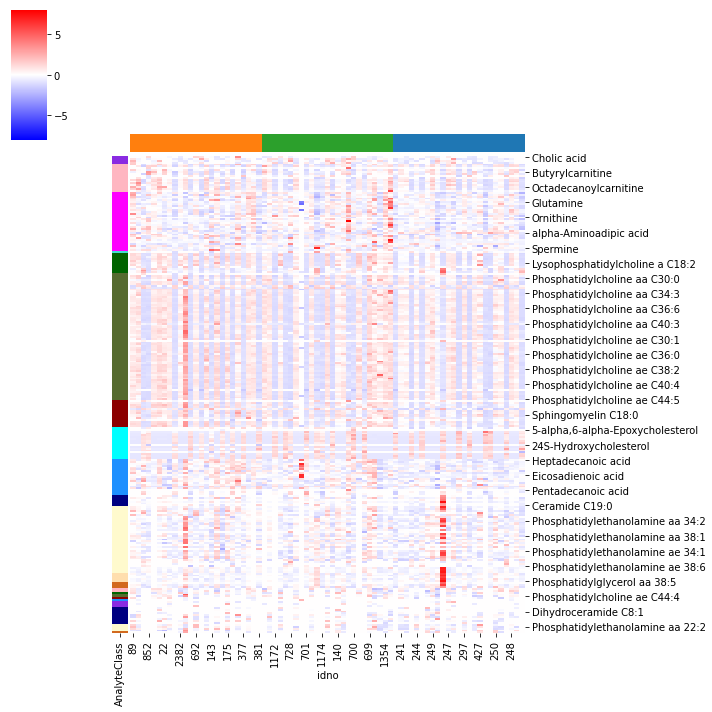

In [4]:
def my_clustermap(dataset, row_cluster=False, col_cluster=False, cmap='bwr'):
    std_df = standardize(dataset)
    row_colors, aclass2color = make_row_colors(std_df)
    col_colors, group2color = make_col_colors(std_df, dataset)
    vmax = std_df.abs().max().max()
    g = sns.clustermap(std_df, row_colors=row_colors, col_colors=col_colors.to_list(), cmap=cmap, row_cluster=row_cluster, col_cluster=col_cluster, vmin=-vmax, vmax=vmax)
    return(g)

g = my_clustermap('brain', row_cluster=False, col_cluster=False)

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


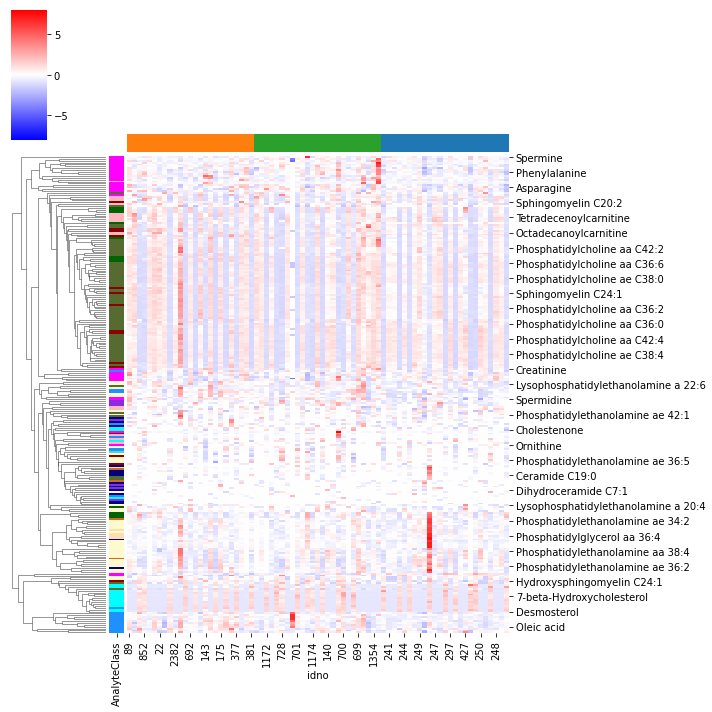

In [5]:
g = my_clustermap('brain', row_cluster=True, col_cluster=False)

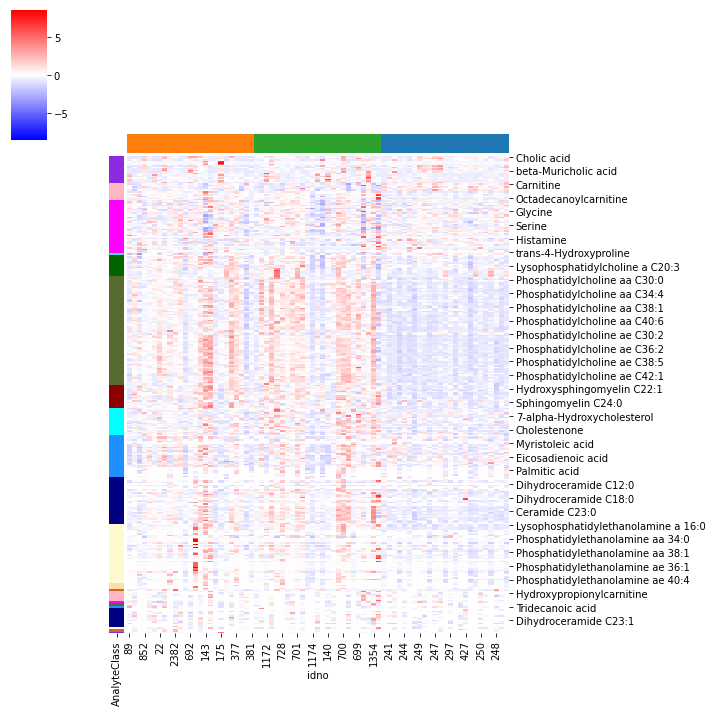

In [6]:
g = my_clustermap('blood', row_cluster=False, col_cluster=False)

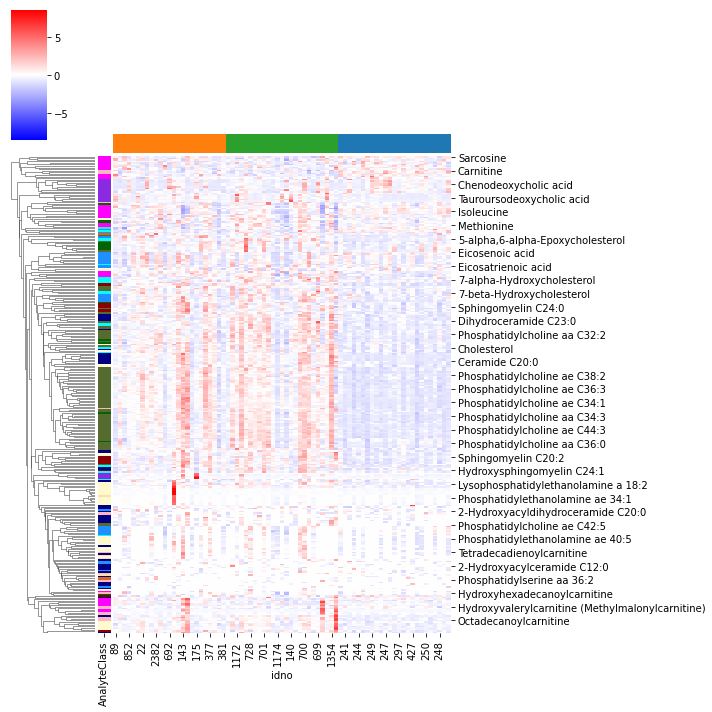

In [7]:
g = my_clustermap('blood', row_cluster=True, col_cluster=False)

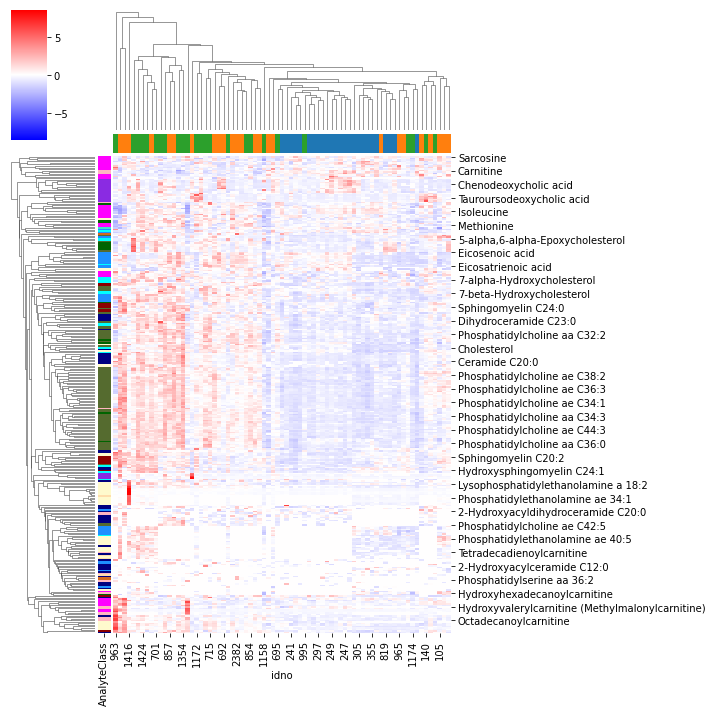

In [8]:
g = my_clustermap('blood', row_cluster=True, col_cluster=True)

In [9]:
%connect_info

{
  "shell_port": 61407,
  "iopub_port": 61408,
  "stdin_port": 61409,
  "control_port": 61411,
  "hb_port": 61410,
  "ip": "127.0.0.1",
  "key": "1a059071-e2298c61b656caa3995245e0",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-fe4a5a29-789c-4c7c-ab97-d94b3fc1c0e8.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
